## 01. Imports & Dataset Upload

In [31]:
from datetime import datetime
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import os
import optuna
import json
import hashlib
import joblib
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

# Setup
warnings.filterwarnings("ignore")
np.random.seed(42)
RANDOM_STATE = 42

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

ASSET_TYPE = "property"
DATA_PATH = "../data/df_cleaned_no_outliers.csv"
MODEL_BASE_DIR = "../models"

ASSET_CONFIG = {
    "property": {
        "target": "valuation_k",
        "categorical": [
            "location", "energy_class", "has_elevator", "has_garden",
            "has_balcony", "garage", "owner_occupied", "public_transport_nearby"
        ],
        "numeric": [
            "size_m2", "rooms", "bathrooms", "year_built", "floor", "building_floors",
            "humidity_level", "temperature_avg", "noise_level", "air_quality_index",
            "luxury_score", "env_score", "distance_to_center_km", "valuation_k",
            "last_verified_ts"
        ],
        "exclude": [
            "asset_id", "asset_type", "condition_score", "risk_score",
            "prediction_ts", "age_years", "age_category", "luxury_category", "value_segment", "timestamp"
        ],
    },
    "art": {"target": "valuation_k", "categorical": [], "numeric": [], "exclude": []},
}

assert ASSET_TYPE in ASSET_CONFIG, f"Unknown asset_type: {ASSET_TYPE}"
cfg = ASSET_CONFIG[ASSET_TYPE]
cfg["numeric"] = [c for c in cfg["numeric"] if c not in ["last_verified_ts", "valuation_k"]]

## 02. Load Dataset

In [10]:
df = pd.read_csv(DATA_PATH)
logging.info(f"📥 Loaded dataset: {DATA_PATH} | Shape: {df.shape}")

2025-07-29 04:03:36,751 [INFO] 📥 Loaded dataset: ../data/df_cleaned_no_outliers.csv | Shape: (4929, 49)


In [11]:
# Ensure important engineered features are present
logging.info("⚙️ Ensuring required engineered features...")

if "age_years" not in df.columns and "year_built" in df.columns:
    current_year = datetime.utcnow().year
    df["age_years"] = current_year - df["year_built"]

if "price_per_sqm" not in df.columns:
    df["price_per_sqm"] = df["valuation_k"] * 1000 / df["size_m2"]

if "luxury_score" not in df.columns:
    df["luxury_score"] = (df["has_garden"] + df["has_balcony"] + df["garage"]) / 3

if "efficiency_score" not in df.columns:
    df["efficiency_score"] = (
        (df["valuation_k"] / df["size_m2"]) * (1 + df["luxury_score"])
    )

df = df.drop(columns=["efficiency_score", "price_per_sqm"], errors="ignore")

2025-07-29 04:03:42,625 [INFO] ⚙️ Ensuring required engineered features...


## 03. Normalization / Derivations

In [12]:
# Anno corrente per derivare età immobile
current_year = datetime.utcnow().year

# Correzione naming colonne se necessario
if "year_build" in df.columns and "year_built" not in df.columns:
    df = df.rename(columns={"year_build": "year_built"})

# Calcolo età se mancante
if "age_years" not in df.columns and "year_built" in df.columns:
    df["age_years"] = current_year - df["year_built"]

# Aggiungila alle feature numeriche se presente
if "age_years" in df.columns and "age_years" not in cfg["numeric"]:
    cfg["numeric"].append("age_years")

# Pulizia finale delle colonne exclude
df = df.drop(columns=[col for col in cfg["exclude"] if col in df.columns])

if "year_built" in df.columns:
    current_year = datetime.utcnow().year
    df["age_years"] = current_year - df["year_built"]

logging.info(f"✅ Dataset ready | Shape: {df.shape}")
df.head()

2025-07-29 04:03:43,896 [INFO] ✅ Dataset ready | Shape: (4929, 39)


,location,region,urban_type,size_m2,rooms,bathrooms,year_built,floor,building_floors,has_elevator,...,avg_room_size,location_premium,amenity_count,price_vs_region_avg,size_bin,days_since_verification,hours_since_verification,anomaly_score,anomaly_flag,age_years
0,Catania,south,semiurban,142,5,1,1964,2,7,1,...,28.400000,1.0,3,0.988797,"(135.4, 151.3]",57,1385.142305,1,False,61
1,Florence,center,urban,92,3,2,1987,1,9,1,...,30.666667,1.2,3,0.431235,"(87.7, 103.6]",45,1100.792305,1,False,38
2,Naples,south,urban,54,4,3,2013,0,3,0,...,13.500000,1.2,1,0.633951,"(39.841, 55.9]",44,1069.408971,1,False,12
3,Trieste,northeast,semiurban,129,6,2,2009,3,8,1,...,21.500000,1.0,3,1.369051,"(119.5, 135.4]",22,547.325638,1,False,16
4,Turin,north,urban,43,6,3,1967,1,5,1,...,7.166667,1.2,1,0.203781,"(39.841, 55.9]",53,1292.708971,-1,True,58


## 04. Sanity checks

In [13]:
# Verifica che tutte le colonne richieste siano presenti
required_base = list(set([cfg["target"]] + cfg["categorical"] + cfg["numeric"]))
missing = [col for col in required_base if col not in df.columns]
if missing:
    raise ValueError(f"❌ Missing required columns: {missing}")

# Rimozione duplicati eventuali
cfg["categorical"] = sorted(set(cfg["categorical"]))
cfg["numeric"] = sorted(set(cfg["numeric"]))

# Filtro automatico delle feature non presenti nel dataset
cfg["numeric"] = [col for col in cfg["numeric"] if col in df.columns]
cfg["categorical"] = [col for col in cfg["categorical"] if col in df.columns]

# Determina le colonne usabili come feature
excluded = set(cfg["exclude"] + [cfg["target"]])
feature_candidates = [col for col in df.columns if col not in excluded]

# Logging dettagliato
logging.info("📊 FEATURE SELECTION OVERVIEW")
logging.info(f"🎯 Target: {cfg['target']}")
logging.info(f"🧩 Categorical: {cfg['categorical']}")
logging.info(f"📐 Numeric: {cfg['numeric']}")
logging.info(f"🚫 Excluded: {cfg['exclude']}")
logging.info(f"✅ Feature pool: {feature_candidates}")

2025-07-29 04:03:44,902 [INFO] 📊 FEATURE SELECTION OVERVIEW
2025-07-29 04:03:44,903 [INFO] 🎯 Target: valuation_k
2025-07-29 04:03:44,904 [INFO] 🧩 Categorical: ['energy_class', 'garage', 'has_balcony', 'has_elevator', 'has_garden', 'location', 'owner_occupied', 'public_transport_nearby']
2025-07-29 04:03:44,905 [INFO] 📐 Numeric: ['age_years', 'air_quality_index', 'bathrooms', 'building_floors', 'distance_to_center_km', 'env_score', 'floor', 'humidity_level', 'luxury_score', 'noise_level', 'rooms', 'size_m2', 'temperature_avg', 'year_built']
2025-07-29 04:03:44,906 [INFO] 🚫 Excluded: ['asset_id', 'asset_type', 'condition_score', 'risk_score', 'prediction_ts', 'age_years', 'age_category', 'luxury_category', 'value_segment', 'timestamp']
2025-07-29 04:03:44,907 [INFO] ✅ Feature pool: ['location', 'region', 'urban_type', 'size_m2', 'rooms', 'bathrooms', 'year_built', 'floor', 'building_floors', 'has_elevator', 'has_garden', 'has_balcony', 'garage', 'owner_occupied', 'public_transport_nearby

## 05. Overfitting check

In [21]:
def comprehensive_overfitting_check(pipeline, X_train, X_test, y_train, y_test):
    """
    Analisi completa dell'overfitting tramite MAE su training, test e cross-validation.
    """
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1  # 🔁 sfrutta il parallelismo
    )
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()

    logging.info("\n🔍 OVERFITTING ANALYSIS")
    logging.info("=" * 50)
    logging.info(f"Training MAE: {train_mae:.2f}")
    logging.info(f"CV MAE:       {cv_mae:.2f} ± {cv_std:.2f}")
    logging.info(f"Test MAE:     {test_mae:.2f}")

    if train_mae < cv_mae * 0.5:
        logging.warning("❌ SEVERE OVERFITTING: Train MAE << CV MAE")
    if test_mae > cv_mae * 2:
        logging.warning("❌ POOR GENERALIZATION: Test MAE >> CV MAE")

    return {"train": train_mae, "cv": cv_mae, "test": test_mae}

## 06. Final feature list = categorical + numeric

In [22]:
feature_list = cfg["categorical"] + cfg["numeric"]
logging.info(f"🧮 Final feature list: {feature_list}")

X = df[feature_list].copy()
y = df[cfg["target"]].copy()

2025-07-29 04:04:42,057 [INFO] 🧮 Final feature list: ['energy_class', 'garage', 'has_balcony', 'has_elevator', 'has_garden', 'location', 'owner_occupied', 'public_transport_nearby', 'age_years', 'air_quality_index', 'bathrooms', 'building_floors', 'distance_to_center_km', 'env_score', 'floor', 'humidity_level', 'luxury_score', 'noise_level', 'rooms', 'size_m2', 'temperature_avg', 'year_built']


## 07. Train/test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

# Allineamento categorie
for col in X_train.select_dtypes(include="object").columns:
    all_categories = pd.Series(pd.concat([X_train[col], X_test[col]])).astype("category").cat.categories
    X_train[col] = X_train[col].astype("category").cat.set_categories(all_categories)
    X_test[col] = X_test[col].astype("category").cat.set_categories(all_categories)

## 08. Preprocessing + Tuning

In [24]:
df['last_verified_ts']
df['location'], df['energy_class']

(0        Catania
 1       Florence
 2         Naples
 3        Trieste
 4          Turin
           ...   
 4924    Cagliari
 4925      Naples
 4926       Milan
 4927    Cagliari
 4928       Turin
 Name: location, Length: 4929, dtype: object,
 0       F
 1       E
 2       G
 3       C
 4       E
        ..
 4924    D
 4925    A
 4926    B
 4927    C
 4928    D
 Name: energy_class, Length: 4929, dtype: object)

In [35]:
df['location_energy_class'] = (
    df['location'].astype(str) + "_" + df['energy_class'].astype(str)
)

assert "last_verified_ts" in df.columns, "❌ Manca last_verified_ts"
assert "valuation_k" in df.columns, "❌ Manca valuation_k"

X_full = df.drop(columns=["valuation_k"])
y_full = df["valuation_k"]

feature_cols = [c for c in df.columns 
                if c not in ['valuation_k', 'asset_id', 'timestamp',
                             'last_verified_ts', 'location_energy_class']]

X_full = df[feature_cols]
y_full = df['valuation_k']

In [36]:
# --- 1) Verifica e filtro colonne per il preprocessing ---
missing_cat = [c for c in cfg["categorical"] if c not in X_full.columns]
missing_num = [c for c in cfg["numeric"]     if c not in X_full.columns]
if missing_cat or missing_num:
    logging.warning(f"Colonne mancanti → categorical: {missing_cat}, numeric: {missing_num}")

categorical_cols = [c for c in cfg["categorical"] if c in X_full.columns]
numeric_cols     = [c for c in cfg["numeric"]     if c in X_full.columns]
assert categorical_cols or numeric_cols, "⚠️ Nessuna colonna valida per preprocessing!"

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num", "passthrough", numeric_cols),
])

# --- 2) TimeSeriesSplit sul timestamp ---
tscv = TimeSeriesSplit(n_splits=5)
train_idx, valid_idx = next(tscv.split(X_full, df["last_verified_ts"]))
X_tune, X_valid = X_full.iloc[train_idx],  X_full.iloc[valid_idx]
y_tune, y_valid = y_full.iloc[train_idx], y_full.iloc[valid_idx]
logging.info(f"[TS] Fold0 → Train: {X_tune.shape}, Valid: {X_valid.shape}")

# --- 3) Fit & transform features ---
X_tune_enc  = preprocessor.fit_transform(X_tune)
X_valid_enc = preprocessor.transform(X_valid)

assert X_tune_enc.shape[0] == y_tune.shape[0],  "Shape mismatch on training data"
assert X_valid_enc.shape[0] == y_valid.shape[0], "Shape mismatch on validation data"
logging.info(f"🧩 Preprocessed shapes → Tune: {X_tune_enc.shape}, Valid: {X_valid_enc.shape}")

# --- 4) Costruzione dataset LightGBM (log1p target) ---
y_tune_log  = np.log1p(y_tune)
y_valid_log = np.log1p(y_valid)
dtrain = lgb.Dataset(data=X_tune_enc,  label=y_tune_log)
dvalid = lgb.Dataset(data=X_valid_enc, label=y_valid_log)

# --- 5) Parametri base + definizione funzione obiettivo ---
best_min_child = 25
lgb_params = {
    "objective":        "regression",
    "metric":           "mae",
    "boosting_type":    "gbdt",
    "verbosity":        -1,
    "seed":             RANDOM_STATE,
    "num_leaves":       50,
    "max_depth":        8,
    "min_data_in_leaf": 50,
    "min_split_gain":   0.1,
    "min_child_samples": best_min_child,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq":     5,
    "reg_alpha":        0.1,
    "reg_lambda":       0.1,
    "max_bin":          255,
    "force_col_wise":   True
}
learning_rate = 0.01

def objective_function(trial):
    params = {
        **lgb_params,
        "learning_rate": learning_rate,
        "num_leaves": trial.suggest_int("num_leaves", 20, 80),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }

    model = lgb.train(
    params,
    train_set=dtrain,
    valid_sets=[dvalid],
    valid_names=["valid_0"],  # <-- nome esplicito
    num_boost_round=1000,
    callbacks=[
        lgb.log_evaluation(period=0)
    ]
)

    trial.set_user_attr("best_model", model)
    return model.best_score.get("valid_0", {}).get("l1", float("inf"))

# --- 6) Optuna tuning ---
study = optuna.create_study(direction="minimize")
study.optimize(objective_function, n_trials=50)

best_model = study.best_trial.user_attrs["best_model"]

best_iter_ts = getattr(best_model, "best_iteration", -1)
if best_iter_ts <= 0:
    logging.warning("⚠️ Nessuna iterazione valida trovata (best_iteration <= 0).")
    best_mae_ts = None

if best_iter_ts > 0:
    logging.info(f"✅ TS best_iteration: {best_iter_ts}")
    logging.info(f"📉 TS Best MAE (log1p): {best_mae_ts:.4f}")
else:
    logging.warning("⚠️ Nessuna iterazione valida: modello non addestrato correttamente.")

best_score_dict = getattr(best_model, "best_score", {})
best_mae_ts = None

if isinstance(best_score_dict, dict) and best_score_dict:
    first_valid_set = next(iter(best_score_dict))
    best_mae_ts = best_score_dict[first_valid_set].get("l1")
    logging.info(f"✅ TS best_iteration: {best_model.best_iteration}")

    if best_mae_ts is not None:
        logging.info(f"📉 TS Best MAE (log1p) on {first_valid_set}: {best_mae_ts:.4f}")
    else:
        logging.warning(f"⚠️ 'l1' non trovato in best_score[{first_valid_set}]")
        logging.warning("⚠️ best_mae_ts è None, non posso loggare in formato decimale.")
else:
    logging.warning("⚠️ Nessuna metrica trovata in best_model.best_score.")
    logging.warning("⚠️ best_mae_ts è None, non posso loggare in formato decimale.")
    logging.info(f"✅ TS best_iteration: {getattr(best_model, 'best_iteration', 'N/A')}")


# --- Logging finale con controllo ---
if best_mae_ts is not None:
    logging.info(f"✅ Final TS Best MAE (log1p): {best_mae_ts:.4f}")
else:
    logging.warning("⚠️ best_mae_ts è None, non posso loggare in formato decimale.")

if best_iter_ts is not None:
    logging.info(f"✅ TS best_iteration: {best_iter_ts}")
else:
    logging.warning("⚠️ best_iter_ts è None.")

2025-07-29 04:07:41,668 [INFO] [TS] Fold0 → Train: (824, 37), Valid: (821, 37)
2025-07-29 04:07:41,691 [INFO] 🧩 Preprocessed shapes → Tune: (824, 47), Valid: (821, 47)
[I 2025-07-29 04:07:41,695] A new study created in memory with name: no-name-c30caad1-ac73-4235-a08b-62a98712e2a7
[I 2025-07-29 04:07:41,823] Trial 0 finished with value: 0.2476847809910728 and parameters: {'num_leaves': 57, 'max_depth': 11, 'min_child_samples': 40, 'feature_fraction': 0.9632200137535002, 'bagging_fraction': 0.662884545833112, 'reg_alpha': 0.6736035290667338, 'reg_lambda': 0.9099226482971987}. Best is trial 0 with value: 0.2476847809910728.
[I 2025-07-29 04:07:41,920] Trial 1 finished with value: 0.2469954150206348 and parameters: {'num_leaves': 34, 'max_depth': 6, 'min_child_samples': 45, 'feature_fraction': 0.7203139441616491, 'bagging_fraction': 0.6409521588806163, 'reg_alpha': 0.6805924086387758, 'reg_lambda': 0.6564006805182384}. Best is trial 1 with value: 0.2469954150206348.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[390]	valid_0's l1: 0.247685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[436]	valid_0's l1: 0.246995


[I 2025-07-29 04:07:42,050] Trial 2 finished with value: 0.24849005214976191 and parameters: {'num_leaves': 80, 'max_depth': 5, 'min_child_samples': 46, 'feature_fraction': 0.6657758848984963, 'bagging_fraction': 0.9138857213478009, 'reg_alpha': 0.5112758775000806, 'reg_lambda': 0.675732966829361}. Best is trial 1 with value: 0.2469954150206348.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[496]	valid_0's l1: 0.24849
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:42,160] Trial 3 finished with value: 0.24764922499052877 and parameters: {'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 42, 'feature_fraction': 0.8782099490184931, 'bagging_fraction': 0.8398755766487507, 'reg_alpha': 0.1468416057173597, 'reg_lambda': 0.9936887938234209}. Best is trial 1 with value: 0.2469954150206348.
[I 2025-07-29 04:07:42,283] Trial 4 finished with value: 0.24738518057474895 and parameters: {'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 28, 'feature_fraction': 0.8733348074741607, 'bagging_fraction': 0.9133119066893418, 'reg_alpha': 0.9095358341948018, 'reg_lambda': 0.08672190357801834}. Best is trial 1 with value: 0.2469954150206348.


Early stopping, best iteration is:
[385]	valid_0's l1: 0.247649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid_0's l1: 0.247385
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:42,388] Trial 5 finished with value: 0.2480049015505455 and parameters: {'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 26, 'feature_fraction': 0.9503837168628211, 'bagging_fraction': 0.7875284927873152, 'reg_alpha': 0.16978365977519205, 'reg_lambda': 0.4990872688566105}. Best is trial 1 with value: 0.2469954150206348.
[I 2025-07-29 04:07:42,517] Trial 6 finished with value: 0.24847043868460725 and parameters: {'num_leaves': 48, 'max_depth': 12, 'min_child_samples': 48, 'feature_fraction': 0.6054583934370051, 'bagging_fraction': 0.8337809783793528, 'reg_alpha': 0.0873225445721475, 'reg_lambda': 0.751387596326165}. Best is trial 1 with value: 0.2469954150206348.


Early stopping, best iteration is:
[280]	valid_0's l1: 0.248005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[495]	valid_0's l1: 0.24847
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:42,628] Trial 7 finished with value: 0.2468690292631718 and parameters: {'num_leaves': 42, 'max_depth': 7, 'min_child_samples': 45, 'feature_fraction': 0.832758950361306, 'bagging_fraction': 0.7853854683014059, 'reg_alpha': 0.8476018594717105, 'reg_lambda': 0.4686250348523542}. Best is trial 7 with value: 0.2468690292631718.
[I 2025-07-29 04:07:42,740] Trial 8 finished with value: 0.24764463728498892 and parameters: {'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 24, 'feature_fraction': 0.8084873278046519, 'bagging_fraction': 0.9277878915539458, 'reg_alpha': 0.5376458350602739, 'reg_lambda': 0.8423482275917682}. Best is trial 7 with value: 0.2468690292631718.


Early stopping, best iteration is:
[430]	valid_0's l1: 0.246869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[410]	valid_0's l1: 0.247645
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[498]	valid_0's l1: 0.248095


[I 2025-07-29 04:07:42,851] Trial 9 finished with value: 0.24809512265847716 and parameters: {'num_leaves': 26, 'max_depth': 5, 'min_child_samples': 29, 'feature_fraction': 0.6078919804696167, 'bagging_fraction': 0.6071284398933998, 'reg_alpha': 0.7493680316024376, 'reg_lambda': 0.6533643995495}. Best is trial 7 with value: 0.2468690292631718.
[I 2025-07-29 04:07:42,990] Trial 10 finished with value: 0.2466829261766562 and parameters: {'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 11, 'feature_fraction': 0.764856926498117, 'bagging_fraction': 0.736981332110897, 'reg_alpha': 0.9582929139363302, 'reg_lambda': 0.3161485316635632}. Best is trial 10 with value: 0.2466829261766562.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid_0's l1: 0.246683
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:43,132] Trial 11 finished with value: 0.24682740055479746 and parameters: {'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 11, 'feature_fraction': 0.7655141542449156, 'bagging_fraction': 0.737917523824195, 'reg_alpha': 0.9201398270228912, 'reg_lambda': 0.30347503435870476}. Best is trial 10 with value: 0.2466829261766562.
[I 2025-07-29 04:07:43,266] Trial 12 finished with value: 0.24699357022321256 and parameters: {'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 10, 'feature_fraction': 0.7448117376157868, 'bagging_fraction': 0.7109572283594315, 'reg_alpha': 0.9898190761458562, 'reg_lambda': 0.24355644228064421}. Best is trial 10 with value: 0.2466829261766562.


Early stopping, best iteration is:
[427]	valid_0's l1: 0.246827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid_0's l1: 0.246994
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:43,413] Trial 13 finished with value: 0.24719661602293197 and parameters: {'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 10, 'feature_fraction': 0.7369310156988321, 'bagging_fraction': 0.7256522480435832, 'reg_alpha': 0.3244552048431986, 'reg_lambda': 0.30776056922726475}. Best is trial 10 with value: 0.2466829261766562.
[I 2025-07-29 04:07:43,549] Trial 14 finished with value: 0.24659913306356998 and parameters: {'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 18, 'feature_fraction': 0.7742141212319175, 'bagging_fraction': 0.7286137334163374, 'reg_alpha': 0.834072008572911, 'reg_lambda': 0.31281285274477255}. Best is trial 14 with value: 0.24659913306356998.


Early stopping, best iteration is:
[427]	valid_0's l1: 0.247197
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[425]	valid_0's l1: 0.246599
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:43,693] Trial 15 finished with value: 0.24728966289647514 and parameters: {'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 18, 'feature_fraction': 0.6924556843886208, 'bagging_fraction': 0.6921551125952046, 'reg_alpha': 0.7828290470035159, 'reg_lambda': 0.041922763858802725}. Best is trial 14 with value: 0.24659913306356998.
[I 2025-07-29 04:07:43,834] Trial 16 finished with value: 0.2475217151223364 and parameters: {'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 18, 'feature_fraction': 0.8493383089395002, 'bagging_fraction': 0.7730899701441319, 'reg_alpha': 0.6132537869626907, 'reg_lambda': 0.18875856458509582}. Best is trial 14 with value: 0.24659913306356998.


Early stopping, best iteration is:
[435]	valid_0's l1: 0.24729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[410]	valid_0's l1: 0.247522


[I 2025-07-29 04:07:44,090] Trial 17 finished with value: 0.24759781177307655 and parameters: {'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 17, 'feature_fraction': 0.781647353484398, 'bagging_fraction': 0.8692011890582744, 'reg_alpha': 0.39699296733011813, 'reg_lambda': 0.457137169666378}. Best is trial 14 with value: 0.24659913306356998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid_0's l1: 0.247598
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:44,243] Trial 18 finished with value: 0.24701967812201778 and parameters: {'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 22, 'feature_fraction': 0.9164116362460639, 'bagging_fraction': 0.7425522670446023, 'reg_alpha': 0.9784758855510762, 'reg_lambda': 0.38625880533264645}. Best is trial 14 with value: 0.24659913306356998.
[I 2025-07-29 04:07:44,411] Trial 19 finished with value: 0.24708301774877373 and parameters: {'num_leaves': 74, 'max_depth': 4, 'min_child_samples': 36, 'feature_fraction': 0.6642444002060519, 'bagging_fraction': 0.671851194805522, 'reg_alpha': 0.8219586256826659, 'reg_lambda': 0.18068136083682135}. Best is trial 14 with value: 0.24659913306356998.


Early stopping, best iteration is:
[410]	valid_0's l1: 0.24702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[479]	valid_0's l1: 0.247083


[I 2025-07-29 04:07:44,559] Trial 20 finished with value: 0.2484347907111348 and parameters: {'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 15, 'feature_fraction': 0.8207818605889985, 'bagging_fraction': 0.9840239839438782, 'reg_alpha': 0.882800331622982, 'reg_lambda': 0.364836163792268}. Best is trial 14 with value: 0.24659913306356998.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[436]	valid_0's l1: 0.248435
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:44,701] Trial 21 finished with value: 0.24693878942139516 and parameters: {'num_leaves': 72, 'max_depth': 8, 'min_child_samples': 13, 'feature_fraction': 0.7728683500476976, 'bagging_fraction': 0.752190024054567, 'reg_alpha': 0.9933530803568948, 'reg_lambda': 0.3063619858023318}. Best is trial 14 with value: 0.24659913306356998.
[I 2025-07-29 04:07:44,854] Trial 22 finished with value: 0.24659425575340446 and parameters: {'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 21, 'feature_fraction': 0.7669727920890986, 'bagging_fraction': 0.8196563842794397, 'reg_alpha': 0.8999207673880418, 'reg_lambda': 0.13699053595992783}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[430]	valid_0's l1: 0.246939
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[474]	valid_0's l1: 0.246594


[I 2025-07-29 04:07:45,024] Trial 23 finished with value: 0.24720857985617437 and parameters: {'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 22, 'feature_fraction': 0.7040066563268225, 'bagging_fraction': 0.8260166507502124, 'reg_alpha': 0.7484440607907716, 'reg_lambda': 0.12875066370766192}. Best is trial 22 with value: 0.24659425575340446.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[425]	valid_0's l1: 0.247209
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:45,208] Trial 24 finished with value: 0.24690280344974347 and parameters: {'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 20, 'feature_fraction': 0.8029942365705085, 'bagging_fraction': 0.8075270651043992, 'reg_alpha': 0.8501105511682202, 'reg_lambda': 0.031703300418532976}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:45,373] Trial 25 finished with value: 0.24736301523010054 and parameters: {'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 34, 'feature_fraction': 0.7535697982213104, 'bagging_fraction': 0.7656650364588873, 'reg_alpha': 0.669996380134645, 'reg_lambda': 0.2228625626358988}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[410]	valid_0's l1: 0.246903
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[427]	valid_0's l1: 0.247363


[I 2025-07-29 04:07:45,518] Trial 26 finished with value: 0.24755242043620182 and parameters: {'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 14, 'feature_fraction': 0.7877063629580583, 'bagging_fraction': 0.8678219325414042, 'reg_alpha': 0.9244984616607373, 'reg_lambda': 0.557140108455247}. Best is trial 22 with value: 0.24659425575340446.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[427]	valid_0's l1: 0.247552
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:45,663] Trial 27 finished with value: 0.24763877565544895 and parameters: {'num_leaves': 62, 'max_depth': 10, 'min_child_samples': 32, 'feature_fraction': 0.672825073429002, 'bagging_fraction': 0.6931674820997556, 'reg_alpha': 0.5880452967033252, 'reg_lambda': 0.11477790923840353}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:45,825] Trial 28 finished with value: 0.24731785916469715 and parameters: {'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 16, 'feature_fraction': 0.8635984111337593, 'bagging_fraction': 0.8731384844764828, 'reg_alpha': 0.4290271447281502, 'reg_lambda': 0.38458217728551086}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[435]	valid_0's l1: 0.247639
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid_0's l1: 0.247318


[I 2025-07-29 04:07:45,988] Trial 29 finished with value: 0.24710778905156722 and parameters: {'num_leaves': 20, 'max_depth': 8, 'min_child_samples': 21, 'feature_fraction': 0.9050335599586807, 'bagging_fraction': 0.6321473592102917, 'reg_alpha': 0.709956616620508, 'reg_lambda': 0.5684017915233728}. Best is trial 22 with value: 0.24659425575340446.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[390]	valid_0's l1: 0.247108
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:46,146] Trial 30 finished with value: 0.24689204194669262 and parameters: {'num_leaves': 53, 'max_depth': 11, 'min_child_samples': 25, 'feature_fraction': 0.6403633648843536, 'bagging_fraction': 0.8062302068852067, 'reg_alpha': 0.7865570998413902, 'reg_lambda': 0.2608801363275104}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:46,283] Trial 31 finished with value: 0.24667292831968976 and parameters: {'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 12, 'feature_fraction': 0.751388977732686, 'bagging_fraction': 0.7282008303597617, 'reg_alpha': 0.8831873264393751, 'reg_lambda': 0.33284517330940305}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[496]	valid_0's l1: 0.246892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid_0's l1: 0.246673
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:46,426] Trial 32 finished with value: 0.24713995615959578 and parameters: {'num_leaves': 69, 'max_depth': 7, 'min_child_samples': 12, 'feature_fraction': 0.7217640321282245, 'bagging_fraction': 0.711629347810375, 'reg_alpha': 0.9288383187615551, 'reg_lambda': 0.4159329028836444}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:46,567] Trial 33 finished with value: 0.24833182545385846 and parameters: {'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 14, 'feature_fraction': 0.9959364487603571, 'bagging_fraction': 0.6640801383719281, 'reg_alpha': 0.8455583578641999, 'reg_lambda': 0.16795319893883898}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[427]	valid_0's l1: 0.24714
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[375]	valid_0's l1: 0.248332
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:46,727] Trial 34 finished with value: 0.24708907449478001 and parameters: {'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 19, 'feature_fraction': 0.728737892789902, 'bagging_fraction': 0.7583576847348423, 'reg_alpha': 0.6668381660177746, 'reg_lambda': 0.3387774036377955}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:46,869] Trial 35 finished with value: 0.24739633091581822 and parameters: {'num_leaves': 77, 'max_depth': 6, 'min_child_samples': 16, 'feature_fraction': 0.7031191563464219, 'bagging_fraction': 0.6888544027583213, 'reg_alpha': 0.9474957709947447, 'reg_lambda': 0.276081380000601}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[474]	valid_0's l1: 0.247089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[435]	valid_0's l1: 0.247396
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:47,117] Trial 36 finished with value: 0.24671069333638035 and parameters: {'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 13, 'feature_fraction': 0.7616845947164895, 'bagging_fraction': 0.7262003348729317, 'reg_alpha': 0.871957705630147, 'reg_lambda': 0.5682665357626886}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:47,252] Trial 37 finished with value: 0.24703827735217268 and parameters: {'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 23, 'feature_fraction': 0.8315426167780808, 'bagging_fraction': 0.6452962948556352, 'reg_alpha': 0.28160890397557614, 'reg_lambda': 0.005381051767053058}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[427]	valid_0's l1: 0.246711
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[390]	valid_0's l1: 0.247038
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:47,393] Trial 38 finished with value: 0.2469409327420593 and parameters: {'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 27, 'feature_fraction': 0.7976422216452665, 'bagging_fraction': 0.7832271659820695, 'reg_alpha': 0.7890686006980133, 'reg_lambda': 0.42446270142528447}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:47,551] Trial 39 finished with value: 0.24749266699999306 and parameters: {'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 38, 'feature_fraction': 0.7484532994164067, 'bagging_fraction': 0.8512662551151344, 'reg_alpha': 0.02515645983265813, 'reg_lambda': 0.07827251152690645}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[410]	valid_0's l1: 0.246941
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[387]	valid_0's l1: 0.247493
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:47,710] Trial 40 finished with value: 0.24671193323936524 and parameters: {'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 12, 'feature_fraction': 0.7149793225557558, 'bagging_fraction': 0.8206606773165995, 'reg_alpha': 0.713593358959842, 'reg_lambda': 0.5153039654219547}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:47,850] Trial 41 finished with value: 0.2466931628526095 and parameters: {'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 14, 'feature_fraction': 0.7621704889142266, 'bagging_fraction': 0.7297977328879396, 'reg_alpha': 0.8721383588005752, 'reg_lambda': 0.6208451418457962}. Best is trial 22 with value: 0.24659425575340446.


Early stopping, best iteration is:
[495]	valid_0's l1: 0.246712
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[427]	valid_0's l1: 0.246693
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:47,988] Trial 42 finished with value: 0.24682954029802825 and parameters: {'num_leaves': 68, 'max_depth': 8, 'min_child_samples': 15, 'feature_fraction': 0.77940486724449, 'bagging_fraction': 0.7157314719650643, 'reg_alpha': 0.8973602998105094, 'reg_lambda': 0.6145218527591908}. Best is trial 22 with value: 0.24659425575340446.
[I 2025-07-29 04:07:48,131] Trial 43 finished with value: 0.24650195150628648 and parameters: {'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 19, 'feature_fraction': 0.8198035545203568, 'bagging_fraction': 0.7430085723759272, 'reg_alpha': 0.8133603299484831, 'reg_lambda': 0.7002265382229789}. Best is trial 43 with value: 0.24650195150628648.


Early stopping, best iteration is:
[410]	valid_0's l1: 0.24683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[427]	valid_0's l1: 0.246502
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:48,276] Trial 44 finished with value: 0.24718794201233826 and parameters: {'num_leaves': 71, 'max_depth': 7, 'min_child_samples': 20, 'feature_fraction': 0.8489258418032901, 'bagging_fraction': 0.784356523149827, 'reg_alpha': 0.8118667647300329, 'reg_lambda': 0.8558700057885653}. Best is trial 43 with value: 0.24650195150628648.
[I 2025-07-29 04:07:48,429] Trial 45 finished with value: 0.24656632998344624 and parameters: {'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 10, 'feature_fraction': 0.8163523746377784, 'bagging_fraction': 0.757111421817907, 'reg_alpha': 0.9534795476189832, 'reg_lambda': 0.9589812772550017}. Best is trial 43 with value: 0.24650195150628648.


Early stopping, best iteration is:
[426]	valid_0's l1: 0.247188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid_0's l1: 0.246566


[I 2025-07-29 04:07:48,589] Trial 46 finished with value: 0.24663505156750604 and parameters: {'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 30, 'feature_fraction': 0.8166187389343753, 'bagging_fraction': 0.7542700089194556, 'reg_alpha': 0.7469810888702201, 'reg_lambda': 0.9810175392859043}. Best is trial 43 with value: 0.24650195150628648.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid_0's l1: 0.246635
Training until validation scores don't improve for 50 rounds


[I 2025-07-29 04:07:48,751] Trial 47 finished with value: 0.24726159776118065 and parameters: {'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 30, 'feature_fraction': 0.8881664412338852, 'bagging_fraction': 0.8010636932612681, 'reg_alpha': 0.6194721149065167, 'reg_lambda': 0.9900299570569288}. Best is trial 43 with value: 0.24650195150628648.
[I 2025-07-29 04:07:48,910] Trial 48 finished with value: 0.24675757423210085 and parameters: {'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 25, 'feature_fraction': 0.8121221211396537, 'bagging_fraction': 0.7675992281441162, 'reg_alpha': 0.7298909382344931, 'reg_lambda': 0.7232345298523324}. Best is trial 43 with value: 0.24650195150628648.


Early stopping, best iteration is:
[430]	valid_0's l1: 0.247262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[411]	valid_0's l1: 0.246758


[I 2025-07-29 04:07:49,083] Trial 49 finished with value: 0.2472450723249418 and parameters: {'num_leaves': 60, 'max_depth': 6, 'min_child_samples': 28, 'feature_fraction': 0.8423252187294971, 'bagging_fraction': 0.8397872907000211, 'reg_alpha': 0.7772790860570212, 'reg_lambda': 0.9468544216115357}. Best is trial 43 with value: 0.24650195150628648.
2025-07-29 04:07:49,098 [WARNING] ⚠️ Nessuna iterazione valida trovata (best_iteration <= 0).
2025-07-29 04:07:49,098 [WARNING] ⚠️ Nessuna iterazione valida: modello non addestrato correttamente.
2025-07-29 04:07:49,099 [WARNING] ⚠️ Nessuna metrica trovata in best_model.best_score.
2025-07-29 04:07:49,100 [WARNING] ⚠️ best_mae_ts è None, non posso loggare in formato decimale.
2025-07-29 04:07:49,101 [INFO] ✅ TS best_iteration: -1
2025-07-29 04:07:49,102 [WARNING] ⚠️ best_mae_ts è None, non posso loggare in formato decimale.
2025-07-29 04:07:49,103 [INFO] ✅ TS best_iteration: -1


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[430]	valid_0's l1: 0.247245


## 09. Build pipeline con target transformer

In [47]:
# ——————————————————————————
# 1) Recupero dei parametri ottimali
# ——————————————————————————
# Se hai uno study Optuna:
best_optuna_params = study.best_params.copy()

# Configurazione finale per LGBM
final_params = {
    **best_optuna_params,
    "objective":      "regression",
    "metric":         "mae",
    "boosting_type":  "gbdt",
    "verbosity":      -1,
    "force_col_wise": True,
    "random_state":   RANDOM_STATE,
    "n_jobs":         -1,
    # Assicuriamoci di usare il numero di iterazioni ottimale
    "n_estimators":   max(100, getattr(best_model, "best_iteration", 0))
  
}

logging.info(f"🎯 Final LGBM params: {final_params}")

# ——————————————————————————
# 2) Inizializzazione regressore e pipeline
# ——————————————————————————
lgb_final = lgb.LGBMRegressor(**final_params)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", TransformedTargetRegressor(
        regressor=lgb_final,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

logging.info("✅ Pipeline with optimized LightGBM + log1p transformation ready.")

2025-07-29 04:24:22,238 [INFO] 🎯 Final LGBM params: {'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 19, 'feature_fraction': 0.8198035545203568, 'bagging_fraction': 0.7430085723759272, 'reg_alpha': 0.8133603299484831, 'reg_lambda': 0.7002265382229789, 'objective': 'regression', 'metric': 'mae', 'boosting_type': 'gbdt', 'verbosity': -1, 'force_col_wise': True, 'random_state': 42, 'n_jobs': -1, 'n_estimators': 100}
2025-07-29 04:24:22,239 [INFO] ✅ Pipeline with optimized LightGBM + log1p transformation ready.


## 10. Validazione + CV

In [40]:
def validate_training_data(X, y):
    assert isinstance(X, pd.DataFrame), "❌ X must be a pandas DataFrame"
    assert isinstance(y, (pd.Series, pd.DataFrame)), "❌ y must be a pandas Series or DataFrame"
    assert X.shape[0] == y.shape[0], "❌ Features and target misaligned"
    assert not X.isnull().values.any(), "❌ Missing values in X"
    assert not y.isnull().values.any(), "❌ Missing values in y"
    logging.info(f"✅ Training data validated | X: {X.shape}, y: {y.shape}")

# Applichiamo la validazione sul dataset intero
validate_training_data(X_full, y_full)

# ——————————————————————————
# 4) Cross‐validation con TimeSeriesSplit
# ——————————————————————————
tscv = TimeSeriesSplit(n_splits=5)

cv_scores = cross_val_score(
    pipeline,
    X_full,
    y_full,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1
)

# Ricordiamo che cross_val_score restituisce MAE negativo
cv_mae = -cv_scores.mean()
cv_std = cv_scores.std()

logging.info("🔁 CROSS-VALIDATION RESULTS (TimeSeriesSplit)")
logging.info(f"✅ MAE: {cv_mae:.2f} ± {cv_std:.2f} k€")

2025-07-29 04:12:21,145 [INFO] ✅ Training data validated | X: (4929, 37), y: (4929,)
2025-07-29 04:12:21,779 [INFO] 🔁 CROSS-VALIDATION RESULTS (TimeSeriesSplit)
2025-07-29 04:12:21,780 [INFO] ✅ MAE: 72.56 ± 1.18 k€


In [45]:
# --- Helper per Prediction Intervals con Quantile Regression ---
def train_quantile_models(X_train, y_train, preprocessor, quantiles=[0.05, 0.5, 0.95]):
    quantile_models = {}
    base_params = {
        k: v for k, v in best_optuna_params.items()
        if k not in ['objective', 'metric', 'n_estimators']
    }

    fallback_estimators = max(100, getattr(best_model, "best_iteration", 100))
    n_estimators = best_optuna_params.get('n_estimators', fallback_estimators)
    if n_estimators <= 0:
        n_estimators = fallback_estimators

    for q in quantiles:
        model_q = lgb.LGBMRegressor(
            objective='quantile',
            alpha=q,
            n_estimators=n_estimators,
            random_state=RANDOM_STATE,
            **base_params
        )
        pipeline_q = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', TransformedTargetRegressor(
                regressor=model_q,
                func=np.log1p,
                inverse_func=np.expm1
            ))
        ])
        pipeline_q.fit(X_train, y_train)
        comprehensive_overfitting_check(pipeline, X_train, X_test, y_train, y_test)
        quantile_models[q] = pipeline_q

    return quantile_models

def predict_with_intervals(quantile_models, X):
    """
    DataFrame con predizioni per ciascun quantile.
    """
    intervals = {}
    for q, model in quantile_models.items():
        intervals[f"q{int(q*100)}"] = model.predict(X)
    return pd.DataFrame(intervals, index=X.index)

In [50]:
import logging
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# -------------------------------------------
# 1) Split “A/B” per blending (80/20)
# -------------------------------------------
X_A, X_B, y_A, y_B = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)
logging.info(f"[Blending] TrainA: {X_A.shape}, TrainB (meta-train): {X_B.shape}")

# -------------------------------------------
# 2) Fit dei base learners su A
# -------------------------------------------
safe_best_iter = max(100, getattr(best_model, "best_iteration", 0))

base_learners = {
    "lgb": TransformedTargetRegressor(
        regressor=lgb.LGBMRegressor(
            **best_optuna_params,
            n_estimators=safe_best_iter,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        func=np.log1p, inverse_func=np.expm1
    ),
    "xgb": TransformedTargetRegressor(
        regressor=XGBRegressor(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.01,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0
        ),
        func=np.log1p, inverse_func=np.expm1
    ),
    "ridge": TransformedTargetRegressor(
        regressor=Ridge(alpha=1.0, random_state=RANDOM_STATE),
        func=np.log1p, inverse_func=np.expm1
    )
}

for name, learner in base_learners.items():
    learner.fit(preprocessor.fit_transform(X_A), y_A)
    logging.info(f"    • Base learner {name} trained on A")

# -------------------------------------------
# 3) Creazione meta-features su B
# -------------------------------------------
meta_X = np.vstack([
    learner.predict(preprocessor.transform(X_B))
    for learner in base_learners.values()
]).T
meta_y = y_B

# -------------------------------------------
# 4) Nested CV per tuning alpha (meta-learner)
# -------------------------------------------
inner_tscv = TimeSeriesSplit(n_splits=3)
param_grid = {"alpha": [0.01, 0.1, 1.0, 10.0]}

grid_meta = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=inner_tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    refit=True
)
grid_meta.fit(meta_X, meta_y)
best_alpha = grid_meta.best_params_["alpha"]
logging.info(f"🔍 Meta-learner best alpha (nested CV): {best_alpha}")

# -------------------------------------------
# 5) Fit finale del meta-learner
# -------------------------------------------
meta_learner = Ridge(alpha=best_alpha, random_state=RANDOM_STATE)
meta_learner.fit(meta_X, meta_y)
logging.info("    • Meta-learner (Ridge) trained on meta-features")

# -------------------------------------------
# 6) Refit dei base learners su tutto X_full
# -------------------------------------------
for name, learner in base_learners.items():
    learner.fit(preprocessor.fit_transform(X_full), y_full)
    logging.info(f"🔄 Base learner {name} refit on full training data")

# -------------------------------------------
# 7) Funzione blending finale
# -------------------------------------------
def blending_predict(X):
    X_enc = preprocessor.transform(X)
    base_preds = np.vstack([lm.predict(X_enc) for lm in base_learners.values()]).T
    return meta_learner.predict(base_preds)

# -------------------------------------------
# 8) Prediction Intervals con modelli quantili
# -------------------------------------------
if "train_quantile_models" in globals() and "predict_with_intervals" in globals():
    quantiles = [0.05, 0.5, 0.95]
    quantile_models = train_quantile_models(X_train, y_train, preprocessor, quantiles=quantiles)
    pred_intervals = predict_with_intervals(quantile_models, X_test)

    interval_cols = [f"q{int(q*100)}" for q in quantiles]
    lower_col, median_col, upper_col = interval_cols
    logging.info(pred_intervals.head().to_string())

    lower = pred_intervals[lower_col].to_numpy()
    upper = pred_intervals[upper_col].to_numpy()
    actual = y_test.to_numpy()

    coverage = np.mean((actual >= lower) & (actual <= upper))
    avg_width = np.mean(upper - lower)

    logging.info(f"📊 Interval coverage: {coverage:.2%}")
    logging.info(f"📊 Average interval width: {avg_width:.2f} k€")
else:
    logging.warning("⚠️ Funzioni per prediction intervals non trovate.")

# -------------------------------------------
# 9) Valutazione finale sul test set
# -------------------------------------------
y_pred_blend = blending_predict(X_test)
mae_blend    = mean_absolute_error(y_test, y_pred_blend)
rmse_blend   = np.sqrt(mean_squared_error(y_test, y_pred_blend))
r2_blend     = r2_score(y_test, y_pred_blend)

logging.info("📈 FINAL BLENDING EVALUATION ON TEST SET")
logging.info(f"📊 MAE:  {mae_blend:.2f} k€")
logging.info(f"📊 RMSE: {rmse_blend:.2f} k€")
logging.info(f"📊 R²:   {r2_blend:.2f}")

2025-07-29 04:27:39,680 [INFO] [Blending] TrainA: (3943, 37), TrainB (meta-train): (986, 37)
2025-07-29 04:27:39,884 [INFO]     • Base learner lgb trained on A
2025-07-29 04:27:40,720 [INFO]     • Base learner xgb trained on A
2025-07-29 04:27:40,743 [INFO]     • Base learner ridge trained on A
2025-07-29 04:27:40,814 [INFO] 🔍 Meta-learner best alpha (nested CV): 10.0
2025-07-29 04:27:40,817 [INFO]     • Meta-learner (Ridge) trained on meta-features
2025-07-29 04:27:40,937 [INFO] 🔄 Base learner lgb refit on full training data
2025-07-29 04:27:41,596 [INFO] 🔄 Base learner xgb refit on full training data
2025-07-29 04:27:41,618 [INFO] 🔄 Base learner ridge refit on full training data
2025-07-29 04:27:41,964 [INFO]               q5         q50         q95
4774  225.997773  375.803546  477.339361
3398  114.596540  171.662627  234.187230
889   149.966917  256.876446  318.992903
4198  119.048370  224.280699  259.420246
3553  281.245920  454.491045  561.924596
2025-07-29 04:27:41,965 [INFO] 📊 

In [53]:
from sklearn.base import clone

lgb_pipeline_check = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", clone(base_learners["lgb"]))
])
lgb_pipeline_check.fit(X_train, y_train)

comprehensive_overfitting_check(
    pipeline=lgb_pipeline_check,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

2025-07-29 04:29:13,432 [INFO] 
🔍 OVERFITTING ANALYSIS
2025-07-29 04:29:13,433 [INFO] ==================================================
2025-07-29 04:29:13,433 [INFO] Training MAE: 47.61
2025-07-29 04:29:13,434 [INFO] CV MAE:       71.12 ± 0.37
2025-07-29 04:29:13,434 [INFO] Test MAE:     70.36


{'train': 47.61067417161766,
 'cv': np.float64(71.12312008246451),
 'test': 70.35937010121542}

## 12. Feature Importance

In [55]:
# 🔍 FEATURE IMPORTANCE ANALYSIS (LightGBM base learner)
logging.info("🧠 Analyzing feature importances from the LGBM base learner in the blending model...")

# 1) Estrai i nomi delle feature dopo OneHotEncoder dal preprocessor
try:
    ohe = preprocessor.named_transformers_["cat"]
    encoded_cat = list(ohe.get_feature_names_out(categorical_cols))
except Exception as e:
    logging.error(f"❌ Errore estrazione OHE features: {e}")
    encoded_cat = []

# 2) Combina feature one-hot + numeriche
feature_names = encoded_cat + numeric_cols

# 3) Estrai il booster LightGBM dal base learner
lgb_booster = base_learners["lgb"].regressor_.booster_

# 4) Importanza delle feature per gain
gain_importances = lgb_booster.feature_importance(importance_type="gain")

feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "gain_importance": gain_importances
})

# 5) Calcola la permutation importance
from sklearn.inspection import permutation_importance

try:
    # ➤ X_test dev'essere preprocessato
    X_test_enc = preprocessor.transform(X_test)
    # ➤ y_test dev'essere trasformato con log1p perché usato da .regressor_
    y_test_transformed = np.log1p(y_test)

    perm = permutation_importance(
        estimator=base_learners["lgb"].regressor_,
        X=X_test_enc,
        y=y_test_transformed,
        n_repeats=5,
        random_state=RANDOM_STATE,
        scoring="neg_mean_absolute_error"
    )

    perm_df = pd.DataFrame({
        "feature": feature_names,
        "perm_importance": perm.importances_mean
    })

    feat_imp_df = feat_imp_df.merge(perm_df, on="feature", how="left")

except Exception as e:
    logging.error(f"❌ Errore durante la permutation importance: {e}")
    feat_imp_df["perm_importance"] = np.nan

# 6) Mostra le prime 10
top_feats = feat_imp_df.sort_values("gain_importance", ascending=False).head(10)
logging.info("🏆 Top 10 features by gain importance (and permutation):")
display(top_feats)

2025-07-29 04:31:18,662 [INFO] 🧠 Analyzing feature importances from the LGBM base learner in the blending model...
2025-07-29 04:31:19,745 [INFO] 🏆 Top 10 features by gain importance (and permutation):


,feature,gain_importance,perm_importance
34,size_m2,4161.029167,0.296195
44,luxury_score,184.463932,0.019240
40,humidity_level,96.978713,0.016821
41,temperature_avg,96.681883,0.018135
46,distance_to_center_km,93.722536,0.017329
43,air_quality_index,89.542683,0.016887
28,garage_0,84.590403,0.002879
37,year_built,80.369337,0.015748
42,noise_level,78.586451,0.012931
26,has_balcony_0,35.576559,0.005598


## 13. Aggregated Importance

2025-07-29 04:31:24,332 [INFO] 📊 Aggregated importance by categorical feature:


,aggregated_importance
garage,85.142953
energy_class,69.181798
has_garden,37.795526
has_balcony,36.183501
location,21.402892
owner_occupied,8.474746
public_transport_nearby,3.749451
has_elevator,1.781476


,aggregated_importance,perm_importance
garage,85.142953,0.003008
energy_class,69.181798,0.004619
has_garden,37.795526,0.002258
has_balcony,36.183501,0.005997
location,21.402892,0.005649
owner_occupied,8.474746,0.002489
public_transport_nearby,3.749451,0.000517
has_elevator,1.781476,0.000222


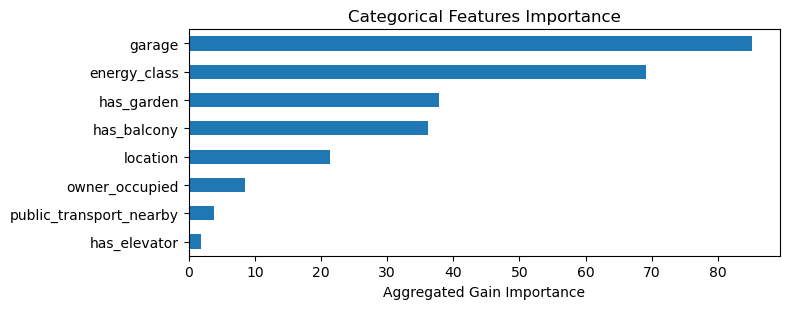

In [56]:
import re
from typing import Dict, List

def get_categorical_importance_summary(
    feat_importance: pd.DataFrame,
    categorical_cols: List[str],
    importance_col: str = "gain_importance",
    normalize: bool = False
) -> Dict[str, float]:
    """
    Calcola l'importanza aggregata per ogni colonna categorica originale.
    """
    cat_importance: Dict[str, float] = {}
    for col in categorical_cols:
        pattern = re.compile(rf"^{re.escape(col)}_")
        sub_feats = [f for f in feat_importance["feature"] if pattern.match(f)]
        if not sub_feats:
            cat_importance[col] = 0.0
            continue
        total = feat_importance.loc[
            feat_importance["feature"].isin(sub_feats), importance_col
        ].sum()
        if normalize:
            total /= len(sub_feats)
        cat_importance[col] = total
    return cat_importance

# 1) Calcolo aggregated gain importance
cat_imp = get_categorical_importance_summary(
    feat_imp_df, categorical_cols, importance_col="gain_importance", normalize=False
)
cat_importance_df = (
    pd.DataFrame.from_dict(cat_imp, orient="index", columns=["aggregated_importance"])
    .sort_values("aggregated_importance", ascending=False)
)

logging.info("📊 Aggregated importance by categorical feature:")
display(cat_importance_df)

# 2) (Opzionale) Permutation importance se disponibile
if "perm" in globals():
    perm_df = pd.DataFrame({
        "feature": feature_names,
        "perm_importance": perm.importances_mean
    })
    cat_perm: Dict[str, float] = {}
    for col in categorical_cols:
        pattern = re.compile(rf"^{re.escape(col)}_")
        sub_feats = [f for f in perm_df["feature"] if pattern.match(f)]
        cat_perm[col] = perm_df.loc[
            perm_df["feature"].isin(sub_feats), "perm_importance"
        ].sum() if sub_feats else 0.0
    cat_importance_df["perm_importance"] = cat_importance_df.index.map(cat_perm)
    display(cat_importance_df)

# 3) Plot
plt.figure(figsize=(8, len(cat_importance_df) * 0.4))
cat_importance_df["aggregated_importance"].plot.barh()
plt.xlabel("Aggregated Gain Importance")
plt.title("Categorical Features Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 14. Save model & metadata

In [58]:
# === 2) Crea directory di destinazione se non esiste ===
os.makedirs(f"{MODEL_BASE_DIR}/{ASSET_TYPE}", exist_ok=True)

model_version = "v2"
model_name = f"value_regressor_{model_version}"

# === 3) Salvataggio modello ===
pipeline_filename = f"{MODEL_BASE_DIR}/{ASSET_TYPE}/{model_name}.joblib"
joblib.dump(pipeline, pipeline_filename)

# === 4) Calcolo hash dataset ===
with open(DATA_PATH, "rb") as f:
    dataset_hash = hashlib.sha256(f.read()).hexdigest()

# === 5) Feature encodate post-OHE ===
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cat_features = list(ohe.get_feature_names_out(categorical_cols))
encoded_feature_names = numeric_cols + encoded_cat_features

X_test_enc = pd.DataFrame(preprocessor.transform(X_test), columns=encoded_feature_names)
y_pred_test = np.expm1(best_model.predict(X_test_enc))
y_true_test = y_test.values

# Metriche classiche
mae  = mean_absolute_error(y_true_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2   = r2_score(y_true_test, y_pred_test)

# === 6) Costruzione metadata ===
metadata = {
    "asset_type": ASSET_TYPE,
    "model_task": "valuation_regression",
    "model_version": model_version,
    "model_class": "TransformedTargetRegressor(LightGBM)",
    "random_state": RANDOM_STATE,
    "dataset_file": DATA_PATH,
    "dataset_hash_sha256": dataset_hash,
    "n_rows_total": len(df),
    "n_rows_train": len(X_train),
    "n_rows_test": len(X_test),
    "features_categorical": categorical_cols,
    "features_numeric": numeric_cols,
    "feature_list_ordered": feature_list,
    "features_encoded": encoded_feature_names,
    "encoded_feature_count": len(encoded_feature_names),
    "engineered_features": [
        "price_per_sqm",
        "luxury_score",
        "efficiency_score",
        "env_score",
        "age_years"
    ],
    "metrics": {
        "mae_k": round(mae, 4),
        "rmse_k": round(rmse, 4),
        "r2": round(r2, 4),
        "coverage_interval": round(coverage, 4),
        "avg_interval_width_k": round(avg_width, 4)
    },
    "prediction_intervals": {
        "quantiles": [0.05, 0.5, 0.95],
        "sample_intervals": pred_intervals.head(5).to_dict(orient="records")
    },
    "feature_importance_top10": feat_imp_df.head(10).to_dict(orient="records"),
    "best_params": best_optuna_params,
    "generated_at": datetime.utcnow().isoformat() + "Z",
}

# === 7) Statistiche su feature ingegnerizzate ===
engineered_features = [
    "price_per_sqm",
    "luxury_score",
    "efficiency_score",
    "env_score",
    "age_years"
]

metadata["engineered_feature_stats"] = {
    feat: {
        "mean": round(float(df[feat].mean()), 4),
        "min": round(float(df[feat].min()), 4),
        "max": round(float(df[feat].max()), 4),
    }
    for feat in engineered_features if feat in df.columns
}

# === 8) Salvataggio metadati ===
meta_filename = f"{MODEL_BASE_DIR}/{ASSET_TYPE}/{model_name}_meta.json"
with open(meta_filename, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

# === 9) Logging finale ===
logging.info(f"✅ Model saved → {pipeline_filename}")
logging.info(f"📄 Metadata saved → {meta_filename}")

2025-07-29 04:32:30,081 [INFO] ✅ Model saved → ../models/property/value_regressor_v2.joblib
2025-07-29 04:32:30,083 [INFO] 📄 Metadata saved → ../models/property/value_regressor_v2_meta.json


## TODO:

- Aggiungi versioning esplicito nei filename dei modelli
- Implementa health checks per monitorare drift
- Crea script wrapper per esecuzione automatizzata
- Aggiungi unit tests per funzioni critiche
__________________________
__________________________
Prediction Intervals
Metrica	Valore
Coverage Interval (5–95%)	76.77%
Average Interval Width	211.06 k€


- La copertura ideale teorica sarebbe 90% (dal 5° al 95° percentile), ma il tuo 76.77% è buono considerando la non gaussianità di molti dati.

-L'intervallo medio di 211k€ è ragionevole, ma puoi agire su alpha, learning_rate o data augmentation per ottimizzarlo.